## Load normalized data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras import models
from keras import layers
import numpy as np

normalized_data = pd.read_csv("../Output/normalized_data.csv", index_col=0)
normalized_data

Using TensorFlow backend.


Survived  Pclass       Age  SibSp     Parch      Fare  female  \
PassengerId                                                                  
1                 0.0     1.0  0.271174    0.2  0.000000  0.014151     0.0   
2                 1.0     0.0  0.472229    0.2  0.000000  0.139136     1.0   
3                 1.0     1.0  0.321438    0.0  0.000000  0.015469     1.0   
4                 1.0     0.0  0.434531    0.2  0.000000  0.103644     1.0   
5                 0.0     1.0  0.434531    0.0  0.000000  0.015713     0.0   
...               ...     ...       ...    ...       ...       ...     ...   
1305              NaN     1.0       NaN    0.0  0.000000  0.015713     0.0   
1306              NaN     0.0  0.484795    0.0  0.000000  0.212559     1.0   
1307              NaN     1.0  0.478512    0.0  0.000000  0.014151     0.0   
1308              NaN     1.0       NaN    0.0  0.000000  0.015713     0.0   
1309              NaN     1.0       NaN    0.2  0.166667  0.043640     0.0   

             male    C    Q  ...  SOTON/O.Q.   2.  STON/O  W./C.  CA.  A/5  \
PassengerId                  ...                                             
1             1.0  0.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  1.0   
2             0.0  1.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
3             0.0  0.0  0.0  ...         0.0  1.0     1.0    0.0  0.0  0.0   
4             0.0  0.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
5             1.0  0.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
...           ...  ...  ...  ...         ...  ...     ...    ...  ...  ...   
1305          1.0  0.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
1306          0.0  1.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
1307          1.0  0.0  0.0  ...         1.0  0.0     0.0    0.0  0.0  0.0   
1308          1.0  0.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
1309          1.0  1.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   

             SC/PARIS  2343   CA  A/5.  
PassengerId                             
1                 0.0   0.0  0.0   0.0  
2                 0.0   0.0  0.0   0.0  
3                 0.0   0.0  0.0   0.0  
4                 0.0   0.0  0.0   0.0  
5                 0.0   0.0  0.0   0.0  
...               ...   ...  ...   ...  
1305              0.0   0.0  0.0   0.0  
1306              0.0   0.0  0.0   0.0  
1307              0.0   0.0  0.0   0.0  
1308              0.0   0.0  0.0   0.0  
1309              0.0   0.0  0.0   0.0  

[1309 rows x 26 columns]

## Counting empty values

In [2]:
empty_values = [(label, normalized_data[label].isnull().sum()) for label in normalized_data.columns.values]
sorted(empty_values, reverse=True, key=lambda tup: tup[1])

[('Survived', 418),
 ('Age', 263),
 ('Pclass', 0),
 ('SibSp', 0),
 ('Parch', 0),
 ('Fare', 0),
 ('female', 0),
 ('male', 0),
 ('C', 0),
 ('Q', 0),
 ('S', 0),
 ('Mr', 0),
 ('Miss', 0),
 ('Mrs', 0),
 ('PC', 0),
 ('C.A.', 0),
 ('SOTON/O.Q.', 0),
 ('2.', 0),
 ('STON/O', 0),
 ('W./C.', 0),
 ('CA.', 0),
 ('A/5', 0),
 ('SC/PARIS', 0),
 ('2343', 0),
 ('CA', 0),
 ('A/5.', 0)]

## Separate samples with and without age

In [3]:
samples_with_age = normalized_data[normalized_data.Age.notna()]
samples_without_age = normalized_data[normalized_data.Age.isna()]

## Creating model for age prediction

In [4]:
x_train_age = samples_with_age.drop(["Age", "Survived"], axis=1).values
y_train_age = samples_with_age["Age"].values

number_of_epochs = 80
number_of_folds = 5
number_of_samples = len(x_train_age) // number_of_folds

all_mae_histories = []
all_val_mae_histories = []
for i in range(number_of_folds):
    print("processing fold #", i)
    partial_x_train_age = np.concatenate([x_train_age[:i*number_of_samples], x_train_age[(i+1)*number_of_samples:]])
    parital_y_train_age = np.concatenate([y_train_age[:i*number_of_samples], y_train_age[(i+1)*number_of_samples:]])
    
    partial_x_validation_age = x_train_age[i*number_of_samples:(i+1)*number_of_samples]
    partial_y_validation_age = y_train_age[i*number_of_samples:(i+1)*number_of_samples]

    model = models.Sequential()
    model.add(layers.Dense(x_train_age.shape[1], activation="relu", input_shape=(x_train_age.shape[1],)))
    model.add(layers.Dense(12, activation="relu"))
    model.add(layers.Dense(1))

    model.compile(optimizer="rmsprop",
                  loss="mse",
                  metrics=["mae"])

    history = model.fit(partial_x_train_age,
                        parital_y_train_age,
                        epochs=number_of_epochs,
                        batch_size=16,
                        validation_data=(partial_x_validation_age, partial_y_validation_age))
    all_mae_histories.append(history.history['mae'])
    all_val_mae_histories.append(history.history['val_mae'])


processing fold # 0
Train on 837 samples, validate on 209 samples
Epoch 1/80
837/837 [==============================] - 0s 240us/step - loss: 0.0362 - mae: 0.1476 - val_loss: 0.0282 - val_mae: 0.1277
Epoch 2/80
837/837 [==============================] - 0s 131us/step - loss: 0.0263 - mae: 0.1260 - val_loss: 0.0257 - val_mae: 0.1263
Epoch 3/80
837/837 [==============================] - 0s 118us/step - loss: 0.0241 - mae: 0.1200 - val_loss: 0.0243 - val_mae: 0.1180
Epoch 4/80
837/837 [==============================] - 0s 134us/step - loss: 0.0229 - mae: 0.1172 - val_loss: 0.0247 - val_mae: 0.1243
Epoch 5/80
837/837 [==============================] - 0s 114us/step - loss: 0.0221 - mae: 0.1150 - val_loss: 0.0246 - val_mae: 0.1175
Epoch 6/80
837/837 [==============================] - 0s 136us/step - loss: 0.0218 - mae: 0.1132 - val_loss: 0.0227 - val_mae: 0.1146
Epoch 7/80
837/837 [==============================] - 0s 116us/step - loss: 0.0212 - mae: 0.1129 - val_loss: 0.0231 - val_mae: 0.1

837/837 [==============================] - 0s 113us/step - loss: 0.0167 - mae: 0.0974 - val_loss: 0.0216 - val_mae: 0.1094
Epoch 62/80
837/837 [==============================] - 0s 215us/step - loss: 0.0168 - mae: 0.0971 - val_loss: 0.0203 - val_mae: 0.1071
Epoch 63/80
837/837 [==============================] - 0s 114us/step - loss: 0.0164 - mae: 0.0963 - val_loss: 0.0206 - val_mae: 0.1085
Epoch 64/80
837/837 [==============================] - 0s 114us/step - loss: 0.0167 - mae: 0.0982 - val_loss: 0.0204 - val_mae: 0.1061
Epoch 65/80
837/837 [==============================] - 0s 121us/step - loss: 0.0166 - mae: 0.0970 - val_loss: 0.0212 - val_mae: 0.1123
Epoch 66/80
837/837 [==============================] - 0s 116us/step - loss: 0.0165 - mae: 0.0970 - val_loss: 0.0206 - val_mae: 0.1063
Epoch 67/80
837/837 [==============================] - 0s 109us/step - loss: 0.0166 - mae: 0.0974 - val_loss: 0.0201 - val_mae: 0.1055
Epoch 68/80
837/837 [==============================] - 0s 121us/ste

837/837 [==============================] - 0s 125us/step - loss: 0.0177 - mae: 0.1019 - val_loss: 0.0216 - val_mae: 0.1149
Epoch 42/80
837/837 [==============================] - 0s 128us/step - loss: 0.0179 - mae: 0.1035 - val_loss: 0.0215 - val_mae: 0.1107
Epoch 43/80
837/837 [==============================] - 0s 114us/step - loss: 0.0178 - mae: 0.1027 - val_loss: 0.0210 - val_mae: 0.1095
Epoch 44/80
837/837 [==============================] - 0s 174us/step - loss: 0.0176 - mae: 0.1027 - val_loss: 0.0221 - val_mae: 0.1099
Epoch 45/80
837/837 [==============================] - 0s 184us/step - loss: 0.0176 - mae: 0.1022 - val_loss: 0.0213 - val_mae: 0.1101
Epoch 46/80
837/837 [==============================] - 0s 135us/step - loss: 0.0176 - mae: 0.1022 - val_loss: 0.0209 - val_mae: 0.1093
Epoch 47/80
837/837 [==============================] - 0s 110us/step - loss: 0.0176 - mae: 0.1022 - val_loss: 0.0210 - val_mae: 0.1108
Epoch 48/80
837/837 [==============================] - 0s 113us/ste

837/837 [==============================] - 0s 176us/step - loss: 0.0180 - mae: 0.1021 - val_loss: 0.0261 - val_mae: 0.1251
Epoch 22/80
837/837 [==============================] - 0s 113us/step - loss: 0.0180 - mae: 0.1017 - val_loss: 0.0277 - val_mae: 0.1271
Epoch 23/80
837/837 [==============================] - 0s 111us/step - loss: 0.0178 - mae: 0.1007 - val_loss: 0.0248 - val_mae: 0.1256
Epoch 24/80
837/837 [==============================] - 0s 115us/step - loss: 0.0180 - mae: 0.1013 - val_loss: 0.0247 - val_mae: 0.1267
Epoch 25/80
837/837 [==============================] - 0s 181us/step - loss: 0.0176 - mae: 0.1009 - val_loss: 0.0245 - val_mae: 0.1250
Epoch 26/80
837/837 [==============================] - 0s 123us/step - loss: 0.0174 - mae: 0.1001 - val_loss: 0.0251 - val_mae: 0.1244
Epoch 27/80
837/837 [==============================] - 0s 115us/step - loss: 0.0174 - mae: 0.1000 - val_loss: 0.0245 - val_mae: 0.1257
Epoch 28/80
837/837 [==============================] - 0s 120us/ste

837/837 [==============================] - 0s 247us/step - loss: 0.0910 - mae: 0.2364 - val_loss: 0.0365 - val_mae: 0.1411
Epoch 2/80
837/837 [==============================] - 0s 109us/step - loss: 0.0310 - mae: 0.1338 - val_loss: 0.0248 - val_mae: 0.1203
Epoch 3/80
837/837 [==============================] - 0s 122us/step - loss: 0.0257 - mae: 0.1224 - val_loss: 0.0233 - val_mae: 0.1129
Epoch 4/80
837/837 [==============================] - 0s 108us/step - loss: 0.0240 - mae: 0.1189 - val_loss: 0.0215 - val_mae: 0.1089
Epoch 5/80
837/837 [==============================] - 0s 117us/step - loss: 0.0229 - mae: 0.1167 - val_loss: 0.0209 - val_mae: 0.1067
Epoch 6/80
837/837 [==============================] - 0s 112us/step - loss: 0.0222 - mae: 0.1149 - val_loss: 0.0204 - val_mae: 0.1059
Epoch 7/80
837/837 [==============================] - 0s 124us/step - loss: 0.0215 - mae: 0.1128 - val_loss: 0.0202 - val_mae: 0.1093
Epoch 8/80
837/837 [==============================] - 0s 127us/step - los

Epoch 62/80
837/837 [==============================] - 0s 112us/step - loss: 0.0171 - mae: 0.1003 - val_loss: 0.0191 - val_mae: 0.1054
Epoch 63/80
837/837 [==============================] - 0s 123us/step - loss: 0.0169 - mae: 0.0996 - val_loss: 0.0198 - val_mae: 0.1100
Epoch 64/80
837/837 [==============================] - 0s 113us/step - loss: 0.0170 - mae: 0.1002 - val_loss: 0.0192 - val_mae: 0.1065
Epoch 65/80
837/837 [==============================] - 0s 119us/step - loss: 0.0170 - mae: 0.0999 - val_loss: 0.0195 - val_mae: 0.1094
Epoch 66/80
837/837 [==============================] - 0s 113us/step - loss: 0.0170 - mae: 0.1006 - val_loss: 0.0196 - val_mae: 0.1041
Epoch 67/80
837/837 [==============================] - 0s 115us/step - loss: 0.0167 - mae: 0.0996 - val_loss: 0.0199 - val_mae: 0.1031
Epoch 68/80
837/837 [==============================] - 0s 121us/step - loss: 0.0168 - mae: 0.0992 - val_loss: 0.0196 - val_mae: 0.1041
Epoch 69/80
837/837 [==============================] - 

837/837 [==============================] - 0s 128us/step - loss: 0.0180 - mae: 0.1018 - val_loss: 0.0187 - val_mae: 0.1082
Epoch 43/80
837/837 [==============================] - 0s 123us/step - loss: 0.0178 - mae: 0.1021 - val_loss: 0.0188 - val_mae: 0.1094
Epoch 44/80
837/837 [==============================] - 0s 113us/step - loss: 0.0178 - mae: 0.1018 - val_loss: 0.0185 - val_mae: 0.1084
Epoch 45/80
837/837 [==============================] - 0s 121us/step - loss: 0.0178 - mae: 0.1018 - val_loss: 0.0180 - val_mae: 0.1065
Epoch 46/80
837/837 [==============================] - 0s 114us/step - loss: 0.0177 - mae: 0.1017 - val_loss: 0.0181 - val_mae: 0.1068
Epoch 47/80
837/837 [==============================] - 0s 120us/step - loss: 0.0175 - mae: 0.1011 - val_loss: 0.0189 - val_mae: 0.1095
Epoch 48/80
837/837 [==============================] - 0s 116us/step - loss: 0.0177 - mae: 0.1013 - val_loss: 0.0187 - val_mae: 0.1070
Epoch 49/80
837/837 [==============================] - 0s 113us/ste

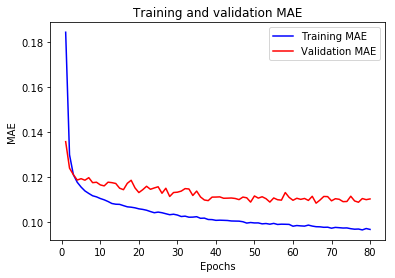

In [5]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(number_of_epochs)]
average_val_mae_history = [np.mean([x[i] for x in all_val_mae_histories]) for i in range(number_of_epochs)]

epochs = range(1, number_of_epochs + 1)

plt.plot(epochs, average_mae_history, "b", label="Training MAE")
plt.plot(epochs, average_val_mae_history, "b", label="Validation MAE", c="red")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()

plt.show()

## Evaluate results for age prediction

In [6]:
results_age = model.predict(samples_without_age.drop(["Survived", "Age"], axis=1))
samples_without_age.loc[:,"Age"] = results_age
samples_without_age

/home/victor/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Survived  Pclass       Age  SibSp     Parch      Fare  female  \
PassengerId                                                                  
6                 0.0     1.0  0.457355    0.0  0.000000  0.016510     0.0   
18                1.0     0.5  0.409413    0.0  0.000000  0.025374     0.0   
20                1.0     1.0  0.344681    0.0  0.000000  0.014102     1.0   
27                0.0     1.0  0.326684    0.0  0.000000  0.014102     0.0   
29                1.0     1.0  0.274098    0.0  0.000000  0.015379     1.0   
...               ...     ...       ...    ...       ...       ...     ...   
1300              NaN     1.0  0.274099    0.0  0.000000  0.015070     1.0   
1302              NaN     1.0  0.274099    0.0  0.000000  0.015127     1.0   
1305              NaN     1.0  0.344905    0.0  0.000000  0.015713     0.0   
1308              NaN     1.0  0.344905    0.0  0.000000  0.015713     0.0   
1309              NaN     1.0  0.034439    0.2  0.166667  0.043640     0.0   

             male    C    Q  ...  SOTON/O.Q.   2.  STON/O  W./C.  CA.  A/5  \
PassengerId                  ...                                             
6             1.0  0.0  1.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
18            1.0  0.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
20            0.0  1.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
27            1.0  1.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
29            0.0  0.0  1.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
...           ...  ...  ...  ...         ...  ...     ...    ...  ...  ...   
1300          0.0  0.0  1.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
1302          0.0  0.0  1.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
1305          1.0  0.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
1308          1.0  0.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
1309          1.0  1.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   

             SC/PARIS  2343   CA  A/5.  
PassengerId                             
6                 0.0   0.0  0.0   0.0  
18                0.0   0.0  0.0   0.0  
20                0.0   0.0  0.0   0.0  
27                0.0   0.0  0.0   0.0  
29                0.0   0.0  0.0   0.0  
...               ...   ...  ...   ...  
1300              0.0   0.0  0.0   0.0  
1302              0.0   0.0  0.0   0.0  
1305              0.0   0.0  0.0   0.0  
1308              0.0   0.0  0.0   0.0  
1309              0.0   0.0  0.0   0.0  

[263 rows x 26 columns]

## Save data

In [7]:
normalized_data_with_predicted_age = pd.concat([samples_with_age, samples_without_age])
normalized_data_with_predicted_age.to_csv("../Output/normalized_data_with_predicted_age.csv", index=True)
normalized_data_with_predicted_age

Survived  Pclass       Age  SibSp     Parch      Fare  female  \
PassengerId                                                                  
1                 0.0     1.0  0.271174    0.2  0.000000  0.014151     0.0   
2                 1.0     0.0  0.472229    0.2  0.000000  0.139136     1.0   
3                 1.0     1.0  0.321438    0.0  0.000000  0.015469     1.0   
4                 1.0     0.0  0.434531    0.2  0.000000  0.103644     1.0   
5                 0.0     1.0  0.434531    0.0  0.000000  0.015713     0.0   
...               ...     ...       ...    ...       ...       ...     ...   
1300              NaN     1.0  0.274099    0.0  0.000000  0.015070     1.0   
1302              NaN     1.0  0.274099    0.0  0.000000  0.015127     1.0   
1305              NaN     1.0  0.344905    0.0  0.000000  0.015713     0.0   
1308              NaN     1.0  0.344905    0.0  0.000000  0.015713     0.0   
1309              NaN     1.0  0.034439    0.2  0.166667  0.043640     0.0   

             male    C    Q  ...  SOTON/O.Q.   2.  STON/O  W./C.  CA.  A/5  \
PassengerId                  ...                                             
1             1.0  0.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  1.0   
2             0.0  1.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
3             0.0  0.0  0.0  ...         0.0  1.0     1.0    0.0  0.0  0.0   
4             0.0  0.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
5             1.0  0.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
...           ...  ...  ...  ...         ...  ...     ...    ...  ...  ...   
1300          0.0  0.0  1.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
1302          0.0  0.0  1.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
1305          1.0  0.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
1308          1.0  0.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   
1309          1.0  1.0  0.0  ...         0.0  0.0     0.0    0.0  0.0  0.0   

             SC/PARIS  2343   CA  A/5.  
PassengerId                             
1                 0.0   0.0  0.0   0.0  
2                 0.0   0.0  0.0   0.0  
3                 0.0   0.0  0.0   0.0  
4                 0.0   0.0  0.0   0.0  
5                 0.0   0.0  0.0   0.0  
...               ...   ...  ...   ...  
1300              0.0   0.0  0.0   0.0  
1302              0.0   0.0  0.0   0.0  
1305              0.0   0.0  0.0   0.0  
1308              0.0   0.0  0.0   0.0  
1309              0.0   0.0  0.0   0.0  

[1309 rows x 26 columns]

## Compare original and predicted Age histograms

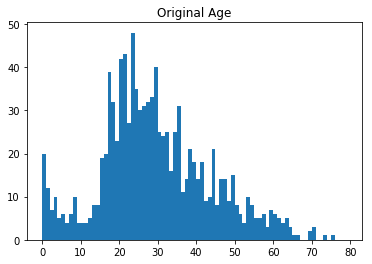

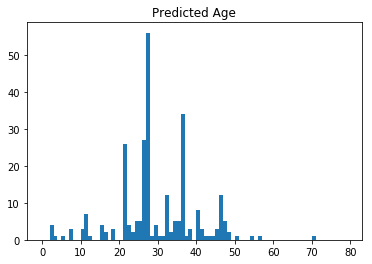

In [39]:
import matplotlib.pyplot as plt
scalar = 80

plt.hist(samples_with_age.Age*scalar, range(scalar))
plt.title("Original Age")
plt.show()

plt.hist(results_age*scalar, range(scalar))
plt.title("Predicted Age")
plt.show()